## Edge detection per color

In [417]:
# ──────────────────────────────────────────────────────────────────────────────
# Imports
# ──────────────────────────────────────────────────────────────────────────────
import cv2
import numpy as np
import math
from collections import defaultdict
import time
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import traceback

In [422]:
# ──────────────────────────────────────────────────────────────────────────────
# Global data holders
# ──────────────────────────────────────────────────────────────────────────────
loaded_image_data = {
    "original": None,
    "bgr_for_processing": None,
    "filename_base": None,
    "height": 0,
    "width": 0,
    "total_area": 0,
    "perimeter_ref": 0,
    "palette": None
}

part1_results = {
    "contours_by_color": {},
    "combined_mask": None,
    "reconstructed": None
}

# ──────────────────────────────────────────────────────────────────────────────
# Helper – load a default quantised image and palette
# ──────────────────────────────────────────────────────────────────────────────
def load_default_image(path="squirtle_quant.png"):
    """Loads an image, extracts palette, and updates global data."""
    try:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED) # Read with alpha if present
        if img is None:
            print(f"Error: Could not load image at {path}")
            # Attempt common relative path for notebooks
            try:
                alt_path = f"../{path}"
                img = cv2.imread(alt_path, cv2.IMREAD_UNCHANGED)
                if img is None:
                     print(f"Error: Could not load image at {alt_path} either.")
                     return
                else:
                     path = alt_path # Use the successful path
            except Exception:
                 return # Failed to load from either path

        # Handle alpha channel if present, otherwise assume 3 channels
        if img.shape[2] == 4:
            img_bgr = img[:, :, :3]
        elif img.shape[2] == 3:
            img_bgr = img
        else:
            print(f"Error: Unsupported number of channels ({img.shape[2]}) in {path}")
            return

        # Extract unique colors (palette) from BGR channels
        palette = np.unique(img_bgr.reshape(-1, 3), axis=0)
        palette_tuples = [tuple(map(int, c)) for c in palette]

        height, width = img_bgr.shape[:2]
        loaded_image_data.update(
            original=img,
            bgr_for_processing=img_bgr,
            filename_base=path.rsplit(".", 1)[0].split('/')[-1], # Get basename without ext
            palette=palette_tuples,
            height=height,
            width=width,
            total_area=float(height * width),
            perimeter_ref=float(2 * (height + width)),
        )
        print(f"Loaded {path}: {width}×{height}, {len(palette_tuples)} unique colours")

    except FileNotFoundError:
        print(f"Error: Image file not found at specified path: {path}")
    except Exception as e:
        print(f"An error occurred during image loading: {e}")
        traceback.print_exc()

# Auto-load on script start (ensure the image exists)
load_default_image()


Loaded squirtle_quant.png: 196×257, 7 unique colours


In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# Helper function for merging contours
# ──────────────────────────────────────────────────────────────────────────────
def group_nearby_contours(contours, max_distance):
    """Groups contours whose bounding boxes are close."""
    if not contours or len(contours) < 2:
        return [[c] for c in contours] # Return list of single-contour groups

    # Calculate bounding boxes once
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    n = len(contours)
    # Efficient grouping using Disjoint Set Union (DSU) or Union-Find
    parent = list(range(n))
    def find_set(v):
        if v == parent[v]:
            return v
        parent[v] = find_set(parent[v])
        return parent[v]

    def unite_sets(a, b):
        a = find_set(a)
        b = find_set(b)
        if a != b:
            parent[b] = a

    for i in range(n):
        xi, yi, wi, hi = bounding_boxes[i]
        center_i_x = xi + wi / 2
        center_i_y = yi + hi / 2
        inflated_xi1, inflated_yi1 = xi - max_distance, yi - max_distance
        inflated_xi2, inflated_yi2 = xi + wi + max_distance, yi + hi + max_distance

        for j in range(i + 1, n):
            xj, yj, wj, hj = bounding_boxes[j]
            center_j_x = xj + wj / 2
            center_j_y = yj + hj / 2

            # Bounding Box Overlap/Proximity Check (more robust than simple center dist)
            # Check if bounding box j intersects with the *inflated* bounding box i
            boxes_intersect = not (
                xj > inflated_xi2 or
                xj + wj < inflated_xi1 or
                yj > inflated_yi2 or
                yj + hj < inflated_yi1
            )

            if boxes_intersect:
                unite_sets(i, j)

    # Collect groups based on DSU structure
    groups_dict = defaultdict(list)
    for k in range(n):
        root = find_set(k)
        groups_dict[root].append(contours[k])

    return list(groups_dict.values())



In [519]:
# ──────────────────────────────────────────────────────────────────────────────
# Core – contour extraction - REVISED with Merging, Outline Filter & Final Check
# ──────────────────────────────────────────────────────────────────────────────
def find_contours_per_color(image_bgr, palette_colors,
                            use_morph_close, morph_ksize,
                            use_merging, merge_distance_px,
                            use_outline_filter, outline_thinness_threshold,
                            dedup_tau, min_area_pct, simplify_eps_frac=0.0005):
    """Finds, processes, and simplifies contours for each color."""
    h, w = image_bgr.shape[:2]
    total_px = h * w
    min_area_px = math.ceil(total_px * (min_area_pct / 100.0))
    if min_area_px < 1: min_area_px = 1 # Ensure minimum area is at least 1 pixel

    contours_passing_filter = defaultdict(list) # Store contours *before* dedup/simplify
    combined_mask_final = np.zeros((h, w), np.uint8)
    initial_contours_total = 0
    merged_groups_total   = 0

    closing_kernel = None
    if use_morph_close and morph_ksize > 1:
        closing_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (morph_ksize, morph_ksize))

    print(f"Processing {len(palette_colors)} colors...")
    processing_start_time = time.time()

    for i, colour_bgr in enumerate(palette_colors):
        colour_bgr_int = tuple(int(c) for c in colour_bgr)
        mask = cv2.inRange(image_bgr, np.array(colour_bgr_int), np.array(colour_bgr_int))
        if cv2.countNonZero(mask) == 0: continue

        processed_mask = mask
        if closing_kernel is not None:
            processed_mask = cv2.morphologyEx(processed_mask, cv2.MORPH_CLOSE, closing_kernel)
        if cv2.countNonZero(processed_mask) == 0: continue

        # --- Step 1: Find Initial Candidate Contours ---
        # Using RETR_TREE allows better hole identification later if needed, but RETR_EXTERNAL is fine for merging stage
        initial_cnts, _ = cv2.findContours(processed_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        n_initial = len(initial_cnts)
        initial_contours_total += n_initial
        if not initial_cnts: continue

        # --- Step 2: Group Contours (Merging) ---
        if use_merging and len(initial_cnts) > 1:
            contour_groups = group_nearby_contours(initial_cnts, merge_distance_px)
        else:
            contour_groups = [[cnt] for cnt in initial_cnts]


        # --- Step 3: Process and Filter Groups/Contours ---
        for group in contour_groups:
            #if not group: continue

            group_mask = np.zeros((h, w), np.uint8)
            cv2.drawContours(group_mask, group, -1, 255, cv2.FILLED)

            # ──────────────── fuse nearby fragments ────────────────
            if use_merging and merge_distance_px > 0:
                # make an elliptical kernel of radius merge_distance_px
                merge_kernel = cv2.getStructuringElement(
                    cv2.MORPH_RECT,
                    (merge_distance_px, merge_distance_px)
                )
                # close any small gaps between fragments
                group_mask = cv2.morphologyEx(
                    group_mask,
                    cv2.MORPH_CLOSE,
                    merge_kernel
                )

            group_cnts_with_holes, group_hierarchy = cv2.findContours(group_mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
            region_mask = np.zeros((h, w), np.uint8)
            if group_hierarchy is not None:
                 group_hierarchy = group_hierarchy[0]
                 for idx, cnt in enumerate(group_cnts_with_holes):
                     if group_hierarchy[idx][3] == -1:
                         cv2.drawContours(region_mask, [cnt], -1, 255, cv2.FILLED)
                         hole_idx = group_hierarchy[idx][2]
                         while hole_idx != -1:
                              cv2.drawContours(region_mask, [group_cnts_with_holes[hole_idx]], -1, 0, cv2.FILLED)
                              hole_idx = group_hierarchy[hole_idx][0]
            elif group_cnts_with_holes: # Handle case with no hierarchy (single contour)
                 cv2.drawContours(region_mask, group_cnts_with_holes, -1, 255, cv2.FILLED)

            effective_area = cv2.countNonZero(region_mask)
            passes_area_filter = (effective_area >= min_area_px)
            passes_outline_filter = False

            if not passes_area_filter and use_outline_filter and outline_thinness_threshold > 0:
                region_boundary_cnts, _ = cv2.findContours(region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                if region_boundary_cnts:
                    perimeter = sum(cv2.arcLength(c, True) for c in region_boundary_cnts)
                    if effective_area > 1e-6:
                        thinness = (perimeter * perimeter) / effective_area
                        if thinness > outline_thinness_threshold:
                            passes_outline_filter = True

            if passes_area_filter or passes_outline_filter:
                combined_mask_final = cv2.bitwise_or(combined_mask_final, region_mask)
                final_boundary_cnts, _ = cv2.findContours(region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                if final_boundary_cnts:
                     contours_passing_filter[colour_bgr_int].extend(final_boundary_cnts)

    print(f"Finished initial processing/filtering in {time.time() - processing_start_time:.2f}s.")

    # --- Post-processing Steps ---
    contours_after_dedup = contours_passing_filter
    if dedup_tau > 0 and sum(len(v) for v in contours_passing_filter.values()) > 1:
        print("Deduplicating contours...")
        dedup_start_time = time.time()
        contours_after_dedup = defaultdict(list)
        all_contours_processed = []
        pos_tol = max(h, w) * 0.01
        area_tol_ratio = 0.10
        def get_contour_props(c):
             # Ensure contour has enough points for moments
             if c is None or len(c) < 5: return None, 0, np.array([0,0])
             moments = cv2.moments(c)
             area = moments["m00"]
             if area < 1e-6: centroid = np.array([0, 0])
             else: centroid = np.array([moments["m10"] / area, moments["m01"] / area])
             return moments, area, centroid

        for col, cnts in contours_passing_filter.items():
            for c in cnts:
                m, a, cent = get_contour_props(c)
                if m is None: continue # Skip degenerate contours immediately
                keep = True
                for kept_c, kept_m, kept_a, kept_cent in all_contours_processed:
                    # Skip comparing if areas are vastly different (quick check)
                    if max(a, kept_a) > 1e-6 and abs(a - kept_a) / max(a, kept_a) > area_tol_ratio + 0.1: continue
                    # Skip comparing if centroids are too far apart (quick check)
                    if np.linalg.norm(cent - kept_cent) > pos_tol * 2 : continue

                    shape_match = cv2.matchShapes(c, kept_c, cv2.CONTOURS_MATCH_I1, 0)
                    centroid_dist = np.linalg.norm(cent - kept_cent)
                    area_diff_ratio = abs(a - kept_a) / max(a, kept_a, 1e-6)
                    if (shape_match < dedup_tau and
                        centroid_dist <= pos_tol and
                        area_diff_ratio <= area_tol_ratio):
                        keep = False; break
                if keep:
                    contours_after_dedup[col].append(c)
                    all_contours_processed.append((c, m, a, cent))
        print(f"Deduplication finished in {time.time() - dedup_start_time:.2f}s.")

    print("Simplifying contours...")
    simplify_start_time = time.time()
    contours_simplified = defaultdict(list)
    total_points_before = 0
    for col, cnts in contours_after_dedup.items():
        for c in cnts:
             if c is None or len(c) < 1: continue # Skip invalid contours
             total_points_before += len(c)
             peri = cv2.arcLength(c, True)
             epsilon = simplify_eps_frac * peri
             approx = cv2.approxPolyDP(c, epsilon, True)
             contours_simplified[col].append(approx) # Store simplified

    print(f"Simplification finished in {time.time() - simplify_start_time:.2f}s.")
    print(f"Simplified contours from {total_points_before} points.")

    # --- FINAL CHECK: Remove Zero Area/Perimeter Contours ---
    print("Performing final validity check...")
    final_check_start_time = time.time()
    contours_truly_final = defaultdict(list)
    final_valid_contour_count = 0
    min_perimeter_epsilon = 1 # Minimum perimeter to keep
    min_area_epsilon = 1     # Minimum area to keep

    for col, cnts in contours_simplified.items():
        valid_contours_for_col = []
        for c in cnts:
            # Basic check: Need at least 3 points for a valid polygon/area
            #if c is None or len(c) < 3:
            #    continue
            # Check Area and Perimeter
            area = cv2.contourArea(c)
            perimeter = cv2.arcLength(c, True)
            # Keep if it has *some* area or *some* perimeter
            if area >= min_area_epsilon or perimeter >= min_perimeter_epsilon:
                 valid_contours_for_col.append(c)

        if valid_contours_for_col:
            contours_truly_final[col] = valid_contours_for_col
            final_valid_contour_count += len(valid_contours_for_col)

    print(f"Final check finished in {time.time() - final_check_start_time:.2f}s.")
    print("––––––––––––––––––––––––––––––––––––––––––––––––––––")
    print(f"RUN SUMMARY:")
    print(f" • raw initial contours : {initial_contours_total}")
    print(f" • merged groups        : {merged_groups_total}")
    print(f" • final valid contours : {final_valid_contour_count}")
    print("––––––––––––––––––––––––––––––––––––––––––––––––––––")
    return contours_truly_final, combined_mask_final



## UI

In [520]:
# ──────────────────────────────────────────────────────────────────────────────
# Widgets for interactive control
# ──────────────────────────────────────────────────────────────────────────────
w_use_close = widgets.Checkbox(value=True, description="Morph Close", indent=False)
w_morph_ksize = widgets.IntSlider(
    value=3, min=1, max=15, step=2, # Default 3 is often safer
    description="Kernel Size:",
    continuous_update=False,
    style={'description_width': 'initial'}
)
w_use_merging = widgets.Checkbox(value=False, description="Merge Nearby", indent=False)
w_merge_distance = widgets.IntSlider(
    value=5, min=0, max=50, step=1,
    description="Merge Dist (px):", continuous_update=False,
    style={'description_width': 'initial'}, disabled=True
)
w_use_outline_filter = widgets.Checkbox(value=True, description="Keep Thin Outlines", indent=False)
w_outline_thinness = widgets.FloatSlider(
    value=50.0, min=00.0, max=1000.0, step=1.0, # Increased max range
    description="Thinness ($P^2/A$):", continuous_update=False,
    style={'description_width': 'initial'}, disabled=False, readout_format='.0f',
)
w_min_area_pct = widgets.FloatSlider(
    value=0.001, min=0.0, max=1.0, step=0.0001, # Finer control, smaller default
    description="Min Area (%):",
    readout_format='.4f',
    continuous_update=False,
    style={'description_width': 'initial'}
)
w_dedup_tau = widgets.FloatSlider(
    value=0.0, min=0.0, max=1.0, step=0.01,
    description="Dedup τ (I1):",
    readout_format='.2f',
    continuous_update=False,
    style={'description_width': 'initial'}
)
w_simplify_eps = widgets.FloatSlider(
    value=0.0005, min=0.0, max=0.01, step=0.0001,
    description="Simplify ε (frac):",
    readout_format='.4f',
    continuous_update=False,
    style={'description_width': 'initial'}
)


# Link enabled status to widgets
def handle_merge_toggle(change): w_merge_distance.disabled = not change.get('new', False)
w_use_merging.observe(handle_merge_toggle, names='value')

def handle_outline_toggle(change): w_outline_thinness.disabled = not change.get('new', False)
w_use_outline_filter.observe(handle_outline_toggle, names='value')

# --- Layout ---
controls_box = widgets.VBox([
    widgets.HTML("<h4>Preprocessing & Merging:</h4>"),
    w_use_close, w_morph_ksize,
    w_use_merging, w_merge_distance,
    widgets.HTML("<h4>Filtering & Simplification:</h4>"),
    w_min_area_pct,
    w_use_outline_filter, w_outline_thinness,
    w_dedup_tau,
    w_simplify_eps,
])
controls_ui = widgets.VBox([
    widgets.HTML("<h3>Part 1 – Mask‑based Contours</h3>"),
    controls_box
])

# ──────────────────────────────────────────────────────────────────────────────
# Update & visualization function
# ──────────────────────────────────────────────────────────────────────────────
out_mask = widgets.Output()
out_outline = widgets.Output()
out_recon = widgets.Output()
out_stats = widgets.Output()

plots_box = widgets.HBox([
    widgets.VBox([widgets.HTML("Combined Mask"), out_mask]),
    widgets.VBox([widgets.HTML("Combined Outline"), out_outline]),
    widgets.VBox([widgets.HTML("Reconstructed"), out_recon]),
])

def update_visual(use_close, ksize,
                  use_merge, merge_dist,
                  use_outline, outline_thresh,
                  tau, min_pct, simplify_eps):
    """Callback function triggered by widget changes."""
    start_time = time.time()
    if loaded_image_data["bgr_for_processing"] is None:
         with out_stats: print("No image loaded.")
         return

    img_bgr = loaded_image_data["bgr_for_processing"]
    palette = loaded_image_data["palette"]
    h, w = loaded_image_data["height"], loaded_image_data["width"]

    # Clear previous outputs - use wait=True for smoother updates
    out_stats.clear_output(wait=True)
    out_mask.clear_output(wait=True)
    out_outline.clear_output(wait=True)
    out_recon.clear_output(wait=True)

    with out_stats: print("Processing...") # Initial message

    # --- Run the core contour finding function ---
    try:
        # Redirect print statements from the core function to the stats output temporarily
        with out_stats:
             # Call the function - its prints will appear in out_stats
             cnts_by_col, comb_mask = find_contours_per_color(
                 img_bgr, palette,
                 use_close, ksize,
                 use_merge, merge_dist,
                 use_outline, outline_thresh,
                 tau, min_pct, simplify_eps
             )

    except Exception as e:
         with out_stats: # Ensure error appears in the correct output widget
              clear_output(wait=True) # Clear "Processing..." message
              print(f"Error during contour processing:\n{e}")
              traceback.print_exc() # Print detailed traceback to console/log
         return

    # Update global results (optional, if needed elsewhere)
    part1_results.update(
        contours_by_color=cnts_by_col,
        combined_mask=comb_mask
    )

    # --- Visualization ---
    # Stats are now printed by find_contours_per_color into out_stats
    # We just need to display the final count summary here
    total_final_contour_count = sum(len(cnts) for cnts in cnts_by_col.values())
    num_colors_with_contours = len(cnts_by_col)

    # Display summary stats *after* processing prints
    with out_stats:
        print("-" * 20)
        print(f"Final Valid Contours: {total_final_contour_count}")
        print(f"Colors with Contours: {num_colors_with_contours} / {len(palette)}")
        print(f"Total Update Time: {time.time() - start_time:.2f}s")

    # Combined Mask
    with out_mask:
        fig_mask, ax_mask = plt.subplots(figsize=(3, 3))
        ax_mask.imshow(comb_mask, cmap="gray")
        ax_mask.axis("off")
        plt.tight_layout(); plt.show(fig_mask); plt.close(fig_mask)

    # Combined Outline
    with out_outline:
        outline_img = np.full_like(img_bgr, 255) # White background
        if total_final_contour_count > 0:
             for col, cnts in cnts_by_col.items():
                  if not cnts: continue
                  draw_color = tuple(map(int, col))
                  try:
                       # Thickness 1 is usually good for outlines
                       cv2.drawContours(outline_img, cnts, -1, draw_color, 1)
                  except Exception as draw_err:
                       print(f"Warning: Error drawing outline contours for color {col}: {draw_err}")
        fig_outline, ax_outline = plt.subplots(figsize=(3, 3))
        ax_outline.imshow(cv2.cvtColor(outline_img, cv2.COLOR_BGR2RGB))
        ax_outline.axis("off")
        plt.tight_layout(); plt.show(fig_outline); plt.close(fig_outline)

    # Reconstructed Image
    with out_recon:
        recon_img = np.full((h, w, 3), 255, dtype=np.uint8) # White background
        areas_by_color = {}
        if total_final_contour_count > 0:
             # Calculate area for sorting based on final valid contours
             for col, cnts in cnts_by_col.items():
                  if not cnts: continue
                  # Create mask efficiently only if needed for sorting
                  # area = sum(cv2.contourArea(c) for c in cnts) # Faster approx area
                  # Or draw for precise area:
                  color_mask = np.zeros((h, w), np.uint8)
                  cv2.drawContours(color_mask, cnts, -1, 255, cv2.FILLED)
                  areas_by_color[col] = cv2.countNonZero(color_mask)

             if areas_by_color: # Check if any colors have area
                  # Sort colors by calculated area (descending)
                  sorted_colors = sorted(areas_by_color.keys(), key=lambda c: areas_by_color[c], reverse=True)

                  # Draw filled contours onto the reconstruction image
                  for col in sorted_colors:
                       cnts = cnts_by_col.get(col) # Use .get for safety
                       if not cnts: continue
                       draw_color = tuple(map(int, col))
                       try:
                            cv2.drawContours(recon_img, cnts, -1, draw_color, cv2.FILLED)
                       except Exception as draw_err:
                            print(f"Warning: Error drawing reconstruction contours for color {col}: {draw_err}")

        part1_results["reconstructed"] = recon_img # Store the result

        fig_recon, ax_recon = plt.subplots(figsize=(3, 3))
        ax_recon.imshow(cv2.cvtColor(recon_img, cv2.COLOR_BGR2RGB))
        ax_recon.axis("off")
        plt.tight_layout(); plt.show(fig_recon); plt.close(fig_recon)

# ──────────────────────────────────────────────────────────────────────────────
# Hook up interactivity and display
# ──────────────────────────────────────────────────────────────────────────────
interactive_output_widget = widgets.interactive_output(
    update_visual,
    {
        "use_close": w_use_close, "ksize": w_morph_ksize,
        "use_merge": w_use_merging, "merge_dist": w_merge_distance,
        "use_outline": w_use_outline_filter, "outline_thresh": w_outline_thinness,
        "tau": w_dedup_tau, "min_pct": w_min_area_pct, "simplify_eps": w_simplify_eps
    }
)


## Display

In [523]:

# --- Final display layout ---
display( controls_ui, out_stats, plots_box )

# --- Trigger initial visualization ---
# Ensure initial call has all arguments corresponding to the interactive output keys
try:
    update_visual(
        w_use_close.value, w_morph_ksize.value,
        w_use_merging.value, w_merge_distance.value,
        w_use_outline_filter.value, w_outline_thinness.value,
        w_dedup_tau.value, w_min_area_pct.value, w_simplify_eps.value
    )
except Exception as initial_run_err:
     with out_stats:
          clear_output(wait=True)
          print(f"Error during initial run: {initial_run_err}")
          traceback.print_exc()


Output()

In [524]:
contours = part1_results["contours_by_color"]

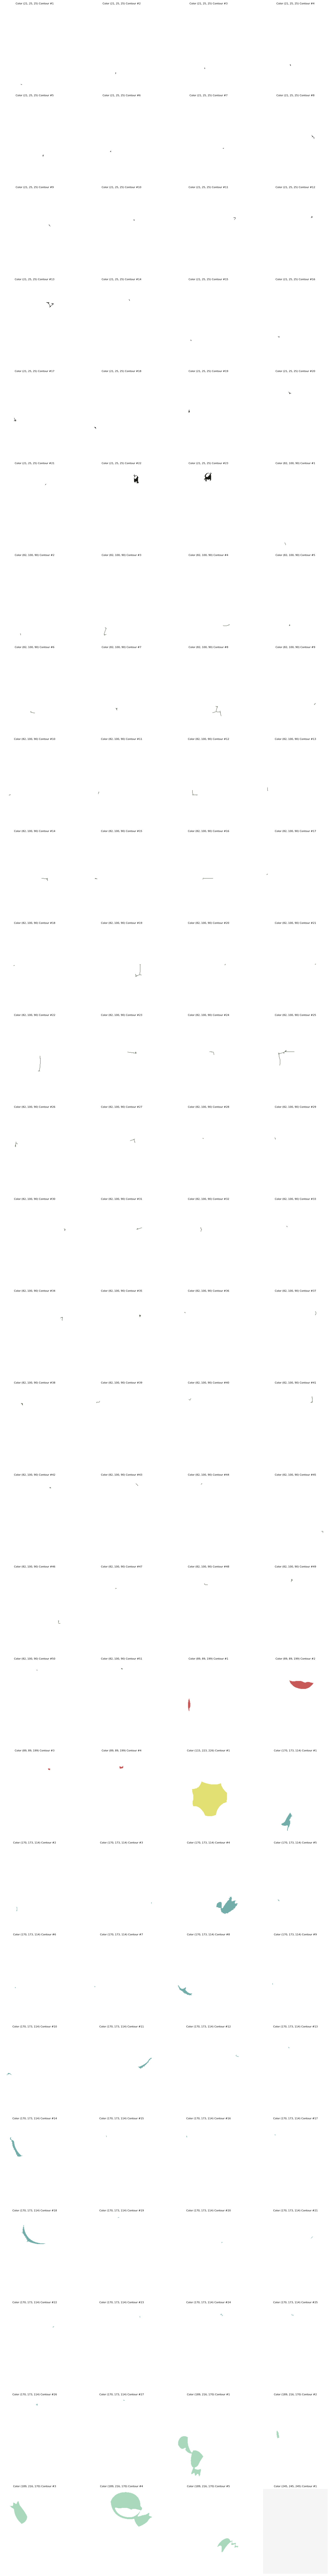

In [525]:
import matplotlib.pyplot as plt
import cv2, math, numpy as np

actual_bg_color = (255, 255, 255)

# Check that contours exist in the global part1_results dictionary.
if not part1_results.get("contours_by_color"):
    print("No contours found in part1_results['contours_by_color']. Please run Part 1 first.")
else:
    # List to store each (title, image) tuple.
    contour_images = []

    # Define a threshold to decide if a color is close to white.
    # For example, if all channels are >= 230, we consider the color to be close to white.
    white_threshold = 230

    # Iterate over each color and its contours.
    for colour, contours in part1_results["contours_by_color"].items():
        # 'colour' is in BGR. We use it as-is for drawing.
        for idx, cnt in enumerate(contours, start=1):
            # Decide on background color:
            # if the palette color is close to white, use a black background; otherwise, use white.
            if all(c >= white_threshold for c in colour):
                bg_color = (0, 0, 0)  # black background
            else:
                bg_color = (255, 255, 255)  # white background

            # Create a canvas with the same dimensions as the original image.
            if(colour != actual_bg_color):
              h, w = loaded_image_data["height"], loaded_image_data["width"]
              canvas = np.full((h, w, 3), bg_color, dtype=np.uint8)

              # Draw the contour filled with its color.
              cv2.drawContours(canvas, [cnt], -1, colour, thickness=cv2.FILLED)

              # Prepare a title showing the BGR color and contour index.
              title = f"Color {tuple(colour)} Contour #{idx}"

              contour_images.append((title, canvas))

    # Display all images on a grid.
    num_images = len(contour_images)
    cols = 4  # number of columns in the grid (adjust as needed)
    rows = math.ceil(num_images / cols)

    plt.figure(figsize=(cols * 4, rows * 4))

    for i, (title, img) in enumerate(contour_images):
        plt.subplot(rows, cols, i + 1)
        # Convert from BGR to RGB for proper display in matplotlib.
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(title, fontsize=8)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Element summary (id → parent, depth, area, peri):
  111 →   - , d=0 , area=49920 , peri=902
    0 → 111 , d=1 , area=0 , peri=7
    4 → 111 , d=1 , area=2 , peri=14
    5 → 111 , d=1 , area=1 , peri=9
    7 → 111 , d=1 , area=2 , peri=30
    8 → 111 , d=1 , area=0 , peri=14
   11 → 111 , d=1 , area=3 , peri=14
   12 → 111 , d=1 , area=19 , peri=82
   14 → 111 , d=1 , area=0 , peri=7
   15 → 111 , d=1 , area=0 , peri=13
   18 → 111 , d=1 , area=7 , peri=20
   19 → 111 , d=1 , area=3 , peri=21
   23 → 111 , d=1 , area=0 , peri=15
   24 → 111 , d=1 , area=0 , peri=9
   25 → 111 , d=1 , area=5 , peri=65
   26 → 111 , d=1 , area=2 , peri=43
   27 → 111 , d=1 , area=4 , peri=10
   28 → 111 , d=1 , area=2 , peri=30
   29 → 111 , d=1 , area=5 , peri=20
   30 → 111 , d=1 , area=6 , peri=123
   34 → 111 , d=1 , area=4 , peri=58
   39 → 111 , d=1 , area=2 , peri=6
   40 → 111 , d=1 , area=0 , peri=5
   41 → 111 , d=1 , area=8 , peri=116
   43 → 111 , d=1 , area=0 , peri=5
   47 → 111 , d=1 , area

C:\Users\adamk\AppData\Local\Temp\ipykernel_21796\3844377412.py:95: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  depth_colors = plt.cm.get_cmap("tab10")   # 10 discrete colours


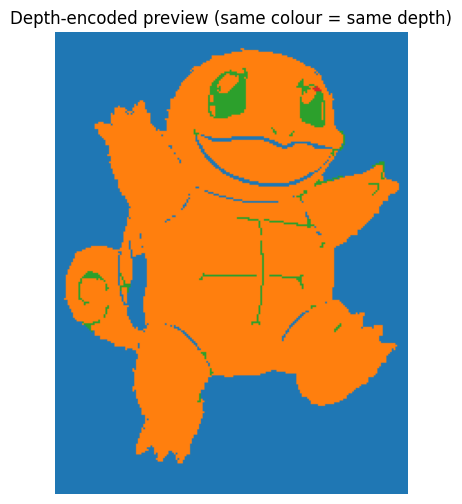

In [526]:
# ==============================================================================
# CELL N+1:  Element properties, ancestry graph, layering heuristic
# ==============================================================================

import cv2, numpy as np, matplotlib.pyplot as plt, math, pprint

# ------------------------------------------------------------------ 0. Inputs
contours_by_color = part1_results["contours_by_color"]
h, w = loaded_image_data["height"], loaded_image_data["width"]

if not contours_by_color:
    raise ValueError("Run Part 1 first – no contours found!")

# ------------------------------------------------------------------ 1. Create element list
elements = []           # list of dicts
id_map   = {}           # contour (Python id) → element dict  (for quick lookup)

for colour, cnts in contours_by_color.items():
    for cnt in cnts:
        area      = cv2.contourArea(cnt)
        peri      = cv2.arcLength(cnt, True)
        M         = cv2.moments(cnt)
        centroid  = np.array([M["m10"] / max(M["m00"], 1e-6),
                              M["m01"] / max(M["m00"], 1e-6)])   # (x,y)
        elem = dict(
            id=len(elements),       # sequential integer id
            colour=tuple(int(c) for c in colour),    # BGR
            contour=cnt,
            area=area,
            perimeter=peri,
            centroid=centroid,
            parent=None,            # to be filled
            children=[],            # list of ids
            depth=None              # to be filled
        )
        elements.append(elem)
        id_map[id(cnt)] = elem

# ------------------------------------------------------------------ 2. Detect "enveloped‑by" (closest parent)
# Pre‑cache bounding‑boxes so we don’t call cv2.boundingRect repeatedly
for e in elements:
    x, y, w_box, h_box = cv2.boundingRect(e["contour"])
    e["bbox"] = (x, y, w_box, h_box)

# For every pair (inner, outer) with outer.area > inner.area
for inner in elements:
    best_parent     = None
    best_area_diff  = float("inf")          # we’ll minimise this

    for outer in elements:
        if outer["area"] <= inner["area"]:
            continue          # parent must be strictly larger

        # --- fast bbox containment test -----------------------------------
        xo, yo, wo, ho = outer["bbox"]
        xi, yi, wi, hi = inner["bbox"]
        if (xo > xi or yo > yi or xo + wo < xi + wi or yo + ho < yi + hi):
            continue          # inner bbox not fully inside → skip quickly

        # --- precise test: inner centroid inside outer? --------------------
        if cv2.pointPolygonTest(outer["contour"],
                                tuple(inner["centroid"]), False) < 0:
            continue

        area_diff = outer["area"] - inner["area"]
        if area_diff < best_area_diff:      # found a more direct envelope
            best_area_diff = area_diff
            best_parent    = outer

    # record the closest enclosing parent (if any)
    if best_parent is not None:
        inner["parent"] = best_parent["id"]
        best_parent["children"].append(inner["id"])

# ------------------------------------------------------------------ 3. Assign depths (root = 0)
def set_depth(elem, d):
    elem["depth"] = d
    for cid in elem["children"]:
        set_depth(elements[cid], d + 1)

for elem in elements:
    if elem["parent"] is None:      # top‑level shapes
        set_depth(elem, 0)

# ------------------------------------------------------------------ 4. Layering heuristic
#    Example rule: sort by (depth    asc,    area desc)
layer_order = sorted(elements, key=lambda e: (e["depth"]))

print("Element summary (id → parent, depth, area, peri):")
for e in layer_order:
    print(f"  {e['id']:>3} → {e['parent'] if e['parent'] is not None else '-':>3} ,"
          f" d={e['depth']} , area={e['area']:.0f} , peri={e['perimeter']:.0f}")

# ------------------------------------------------------------------ 5. Quick visual check – colour‑coded by depth
depth_colors = plt.cm.get_cmap("tab10")   # 10 discrete colours
canvas = np.full((h, w, 3), 255, np.uint8)

for e in layer_order:                     # paint in layering order
    fake_color = tuple(int(c*255) for c in depth_colors(e["depth"] % 10)[:3][::-1])
    cv2.drawContours(canvas, [e["contour"]], -1, fake_color, cv2.FILLED)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title("Depth‑encoded preview (same colour = same depth)")
plt.axis("off")
plt.show()

# ------------------------------------------------------------------ 6. (OPTIONAL) export the 'elements' list for later use
# e.g.  with pickle / JSON, or keep it in memory for further processing.
#pprint.pprint(elements[:5])   # peek at first few entries


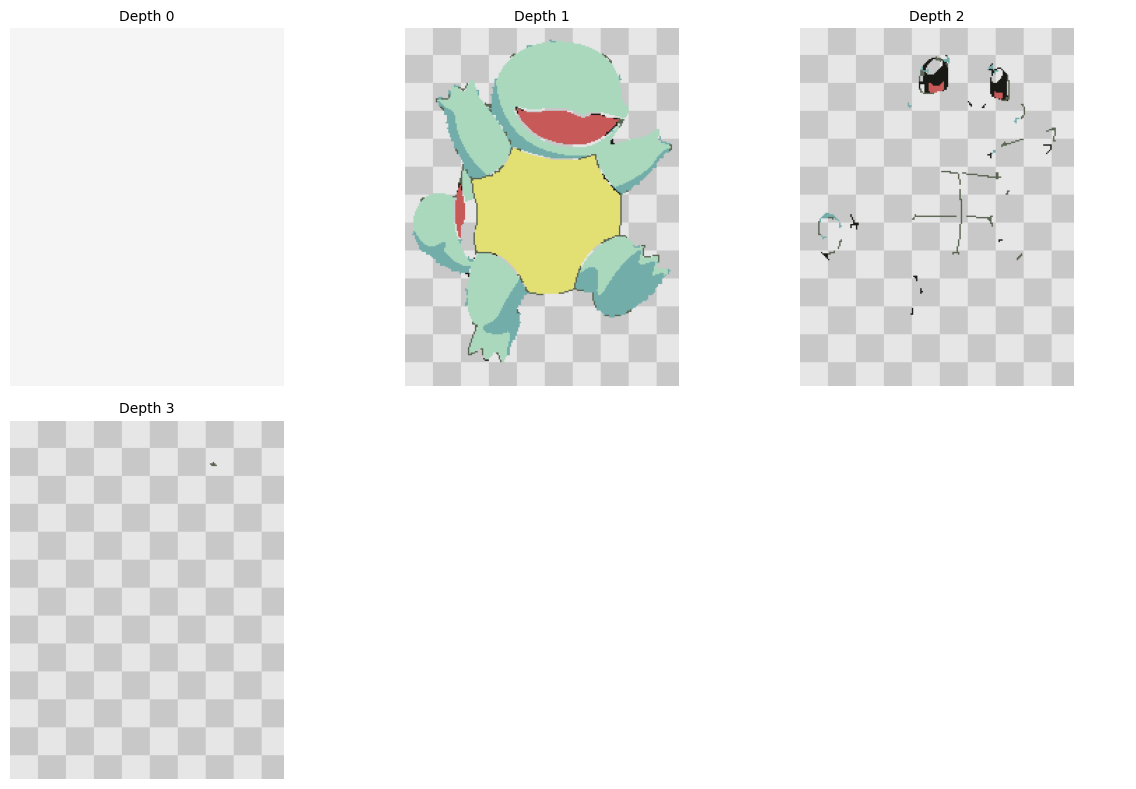

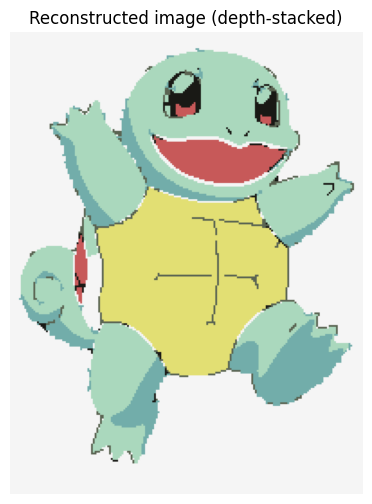

In [527]:
# ==============================================================================
# CELL N+3:  Depth previews + final reconstruction
# ==============================================================================

import cv2, numpy as np, matplotlib.pyplot as plt, math

# --- 0. Sanity checks ---------------------------------------------------------
if not elements or any(e["depth"] is None for e in elements):
    raise ValueError("Run the ancestry cell first to populate 'elements' with depth.")

h, w = loaded_image_data["height"], loaded_image_data["width"]

# --- 1. Helper – checkerboard background -------------------------------------
def make_checkerboard(height, width, block=20,
                      color_a=(230, 230, 230), color_b=(200, 200, 200)):
    yy, xx = np.indices((height, width))
    pattern = ((yy // block) + (xx // block)) % 2
    board   = np.empty((height, width, 3), np.uint8)
    board[pattern == 0] = color_a
    board[pattern == 1] = color_b
    return board

# --- 2. Create one canvas per depth ------------------------------------------
depth_levels   = sorted({e["depth"] for e in elements})
depth_canvases = []                          # list of (depth, BGR image)

for d in depth_levels:
    canvas = make_checkerboard(h, w)
    for e in elements:
        if e["depth"] == d:
            cv2.drawContours(canvas, [e["contour"]], -1, e["colour"], cv2.FILLED)
    depth_canvases.append((d, canvas))

# --- 3. Display depth previews -----------------------------------------------
cols = 3
rows = math.ceil(len(depth_canvases) / cols)
plt.figure(figsize=(cols * 4, rows * 4))

for idx, (d, img_bgr) in enumerate(depth_canvases, 1):
    plt.subplot(rows, cols, idx)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(f"Depth {d}", fontsize=10)
    plt.axis("off")

for blank in range(idx + 1, rows * cols + 1):
    plt.subplot(rows, cols, blank); plt.axis("off")

plt.tight_layout()
plt.show()

# --- 4. Final reconstructed image (paint depth 0 → max) ----------------------
reconstructed = make_checkerboard(h, w)     # start with same checkerboard

for d in depth_levels:                      # ascending depth order
    for e in elements:
        if e["depth"] == d:
            cv2.drawContours(reconstructed, [e["contour"]], -1, e["colour"], cv2.FILLED)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB))
plt.title("Reconstructed image (depth‑stacked)")
plt.axis("off")
plt.show()


In [105]:
import os
import cv2
import numpy as np

def contour_to_svg_path(cnt):
    """
    Convert a contour (numpy array of points) into an SVG 'd' path string.
    """
    # Reshape contour to an array of (x,y) points
    points = cnt.reshape(-1, 2)
    if len(points) == 0:
        return ""
    # Create path data string: Move to first point, then line-to subsequent, and close path.
    d = f"M {points[0][0]} {points[0][1]} " + " ".join(f"L {x} {y}" for x, y in points[1:]) + " Z"
    return d

def bgr_to_hex(bgr):
    """ Convert a BGR tuple (int, int, int) to a hex color string (e.g., '#rrggbb'). """
    # Reverse the order to get RGB.
    r, g, b = bgr[2], bgr[1], bgr[0]
    return f"#{r:02x}{g:02x}{b:02x}"

# Create an output folder for SVG files.
output_folder = "exported_svgs"
os.makedirs(output_folder, exist_ok=True)

# Get the image dimensions from loaded_image_data.
img_width  = loaded_image_data["width"]
img_height = loaded_image_data["height"]

# Counter for all exported files.
export_count = 0

# Iterate over each color and corresponding list of contours.
for colour, contours in part1_results.get("contours_by_color", {}).items():
    # Convert the BGR color to hex for use in SVG.
    svg_color = bgr_to_hex(colour)

    # For each contour for this palette color
    for idx, cnt in enumerate(contours, start=1):
        # Convert contour to SVG path data.
        d = contour_to_svg_path(cnt)
        # Get bounding box metadata (position & size)
        x, y, w, h = cv2.boundingRect(cnt)

        # Create metadata strings
        meta_title = f"Contour {idx} for color {colour}"
        meta_desc  = f"Bounding box: x={x}, y={y}, w={w}, h={h}; Total contours for this color: {len(contours)}"

        # Build the SVG content.
        # We include a <title> and <desc> for metadata.
        svg_content = f'''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<svg xmlns="http://www.w3.org/2000/svg" width="{img_width}" height="{img_height}" viewBox="0 0 {img_width} {img_height}">
  <title>{meta_title}</title>
  <desc>{meta_desc}</desc>
  <path d="{d}" fill="{svg_color}" stroke="none" />
</svg>
'''
        # Create a file name using the color and contour index.
        filename = f"contour_{colour[0]}_{colour[1]}_{colour[2]}_{idx}.svg"
        filepath = os.path.join(output_folder, filename)

        # Write the SVG file.
        with open(filepath, "w", encoding="utf-8") as f:
            f.write(svg_content)
        export_count += 1

print(f"Exported {export_count} contour SVG files to folder '{output_folder}'.")


Exported 21 contour SVG files to folder 'exported_svgs'.


## Layer estimation